# SPISEA Quick Start: Making A Cluster

This is a quick start guide to making a synthetic cluster using the SPISEA package. The cluster is constructed using a user-specified isochrone and initial mass function (IMF). Detailed documentation is provided in the ReadtheDocs page (https://spisea.readthedocs.io/en/latest/index.html).

Before starting this tutorial, it is assumed that SPISEA has been installed and the user's python path has been altered to include the SPISEA top-level directory

In [1]:
# Import necessary packages. 
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt
%matplotlib inline

/Users/mwhosek/anaconda3/envs/astroconda2/lib/python3.6/site-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in /Users/mwhosek/models/models_2019_07/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


#### Step 1: Make a SPISEA isochrone object

The cluster is made from a theoretical isochrone at a given age, extinction, and distance from Earth. These parameters MUST be specified by the user. Other inputs (e.g. stellar evolution/atmosphere models, extinction law, and photometric filters used) are optional keywords. See documentation for all keywords and their default values.

Important Note: The IsochronePhot class saves its output as a FITS table, which it will read on subsequent calls for the same isochrone rather than regenerating it from scratch. We highly recommend reading the "Tips and Tricks: The IsochronePhot Object" section of the Isochrone object documentation for details on how this process works.

Here, we create a 5 Myr cluster isochrone at an extinction of 0.8 mags and distance of 4000 pc from Earth. 

In [2]:
# Define isochrone parameters
logAge = np.log10(5*10**6.) # Age in log(years)
AKs = 0.8 # extinction in mags
dist = 4000 # distance in parsec
metallicity = 0 # Metallicity in [M/H]

# Define evolution/atmosphere models and extinction law
evo_model = evolution.MISTv1() 
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()

# Also specify filters for synthetic photometry (optional). Here we use 
# the HST WFC3-IR F127M, F139M, and F153M filters
filt_list = ['wfc3,ir,f127m', 'wfc3,ir,f139m', 'wfc3,ir,f153m']

# Specify the directory we want the output isochrone
# table saved in. If the directory does not already exist,
# SPISEA will create it.
iso_dir = 'isochrones/'

# Make IsochronePhot object. Note that this will take a minute or two, 
# unless the isochrone has been generated previously.
#
# Note that this is not show all of the user options 
# for IsochronePhot. See docs for complete list of options.
my_iso = synthetic.IsochronePhot(logAge, AKs, dist, metallicity=0,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)

Once calculated, the isochrone will be written as a fits file to a location set by the "iso_dir" keyword (note: if iso_dir is not defined, the isochrone is saved in the current working directory by default). In the future, the IsochronePhot function will read this file directly rather than recalculating the isochrone again. 

The output file is named as: "iso_logAge_AKs_distance_metallicity.fits, using the specified values

In [3]:
# The stars in the isochrone and associated properties  
# are stored in an astropy table called "points" 
# within the IsochronePhot object. 
print(my_iso.points)

          L                   Teff        ...    m_hst_f153m    
          W                    K          ...                   
---------------------- ------------------ ... ------------------
 8.660109049222469e+24  2997.482453641835 ...   21.1520214464892
 9.046193280874383e+24 3008.7858260184175 ...  21.10504146353302
 9.449142476745298e+24 3020.1687795233192 ... 21.058402938607138
 9.869958611246552e+24  3031.631609685951 ... 21.011969614391397
 1.076707529684324e+25 3054.6500837349886 ... 20.919821469819336
1.0829426036763875e+25 3065.3879429582494 ...  20.91549975563932
1.1480726894593663e+25  3078.908328291189 ... 20.853895984633194
 1.221834686575575e+25  3093.002145149403 ...  20.78833906517428
1.3043887291289771e+25 3107.5858797888227 ...  20.71737738946115
1.3956010100862058e+25 3122.5861578385725 ...  20.64218049228478
                   ...                ... ...                ...
 3.146902975957394e+32 13997.739388490047 ...  5.930259429682409
3.1460717791216517e+32 13

In [4]:
# The isochrone table has meta keywords describing its input properties:
# REDLAW: which redlaw object was used
# ATMFUNC: atmosphere grid was used
# EVOMODEL: evolution model grid used
# LOGAGE: log(Age) of isochrone
# AKS: total extinction used
# DISTANCE: distance used
# METAL_IN: metallicity requested by user, in [M/H]
# METAL_ACT: actual metallicity of model, in [M/H] 
# (only relevant if user chooses metallicity other than defined grid-points)
# WAVEMIN, WAVEMAX: the minimum and maximum wavelengths of the stellar spectra (angstroms)
print(my_iso.points.meta)

OrderedDict([('REDLAW', 'H18b'), ('ATMFUNC', 'get_merged_atmosphere'), ('EVOMODEL', 'MISTv1'), ('LOGAGE', 6.698970004336019), ('AKS', 0.8), ('DISTANCE', 4000), ('METAL_IN', 0), ('METAL_ACT', 0.02380291467262473), ('WAVEMIN', 3000), ('WAVEMAX', 52000)])


In [5]:
# See Isochrone Object documentation for column definitions
print('The columns in the isochrone table are: {0}'.format(my_iso.points.keys()))

The columns in the isochrone table are: ['L', 'Teff', 'R', 'mass', 'logg', 'isWR', 'mass_current', 'phase', 'm_hst_f127m', 'm_hst_f139m', 'm_hst_f153m']


In [6]:
# Example case:
# Identify a 1 M_sun star, print F127M, F139M, and F153M mags
idx = np.where( abs(my_iso.points['mass'] - 1.0) == min(abs(my_iso.points['mass'] - 1.0)) )[0]
f127m = np.round(my_iso.points[idx[0]]['m_hst_f127m'], decimals=3)
f139m = np.round(my_iso.points[idx[0]]['m_hst_f139m'], decimals=3)
f153m = np.round(my_iso.points[idx[0]]['m_hst_f153m'], decimals=3)
print('1 M_sun: F127M = {0} mag, F139M = {1} mag, F153M = {2} mag'.format(f127m, f139m, f153m))

1 M_sun: F127M = 19.047 mag, F139M = 18.446 mag, F153M = 17.773 mag


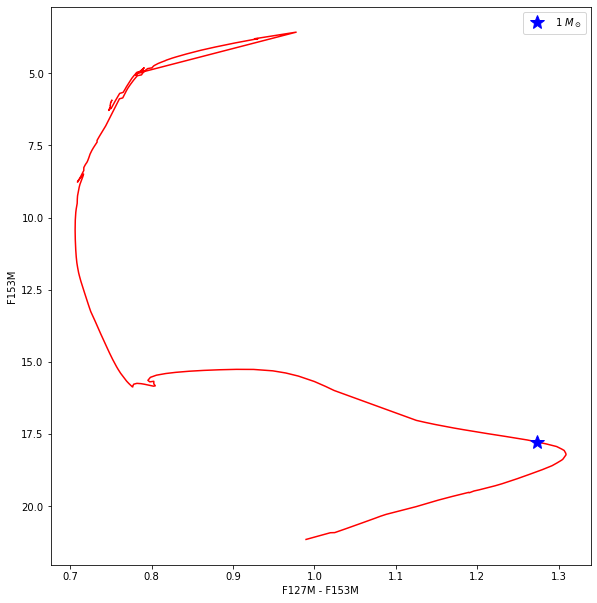

In [7]:
# Make a color-magnitude diagram from the isochrone
py.figure(1, figsize=(10,10))
py.clf()
py.plot(my_iso.points['m_hst_f127m'] - my_iso.points['m_hst_f153m'], 
       my_iso.points['m_hst_f153m'], 'r-', label='_nolegend_')
py.plot(my_iso.points['m_hst_f127m'][idx] - my_iso.points['m_hst_f153m'][idx], 
       my_iso.points['m_hst_f153m'][idx], 'b*', ms=15, label='1 $M_\odot$')
py.xlabel('F127M - F153M')
py.ylabel('F153M')
py.gca().invert_yaxis()
py.legend()

### Step 2: Make an Initial Mass Function

SPISEA offers a range of initial mass functions (IMFs) a user can use from to make the cluster. In addition to the parameters defining the IMF, the user can input a SPISEA multiplicity object, which defines the multiplicity properties of the population. The default multiplicity is None (e.g. all stars are single).

Here we define a Kroupa IMF using the Multiplicity properties defined in Lu+13. 

In [8]:
# Make multiplicity object Here, we use the MultiplicityUnresolved object, 
# based on Lu+13. This means that star systems will be unresolved, i.e., 
# that all components of a star system are combined into a single "star" in the cluster
imf_multi = multiplicity.MultiplicityUnresolved()

# Make IMF object; we'll use a broken power law with the parameters from Kroupa+01

# NOTE: when defining the power law slope for each segment of the IMF, we define
# the entire exponent, including the negative sign. For example, if dN/dm $\propto$ m^-alpha,
# then you would use the value "-2.3" to specify an IMF with alpha = 2.3. 

massLimits = np.array([0.2, 0.5, 1, 120]) # Define boundaries of each mass segement
powers = np.array([-1.3, -2.3, -2.3]) # Power law slope associated with each mass segment
my_imf = imf.IMF_broken_powerlaw(massLimits, powers, imf_multi)

### Step 3: Make the Cluster  
#### Option 1: Resolved Cluster without compact objects

Here we make a resolved cluster using the ResolvedCluster object. 

To create the cluster, the user passes in an isochrone object, and imf object, and specifies the total cluster mass. Here we will make a 10^5 M_sun cluster using the isochrone and imf we have defined. 

###### Some Notes
1. Unless an IFMR object is defined, no compact objects are included. Stars that have evolved into compact objects will be dropped from the cluster. 
2. Stars generated by the IMF object that have masses below the lowest mass in the evolution model are dropped from the cluster.
2. If you wish to create a cluster with differential extinction included in the output photometry, then you can use the ResolvedClusterDiffRedden object. It is the same as ResolvedCluster, but with an additional parameter to define dAKs, which characterizes the spread of extinction within the cluster

In [9]:
# Define total cluster mass
mass = 10**5.

# Make cluster object
cluster = synthetic.ResolvedCluster(my_iso, my_imf, mass)

Found 74 stars out of mass range


The individual stars (or star systems) in the cluster are stored in an astropy table called "star_systems" within the cluster object. If a multiplicity object is used, then an additional "companions" table is created that contains the properties of the companions to the primary star within each star system. See cluster object documentation for a description of the columns in these tables. 

If a multiplicity object is used, then the photometry in the star_systems table is the COMBINED photometry of the system; it includes the contributions from all companions.

In [10]:
# Look at star systems table
print(cluster.star_systems)

        mass        isMultiple ...    m_hst_f153m     N_companions
------------------- ---------- ... ------------------ ------------
 0.6876030977679913      False ... 18.389044207067464            0
 0.5955047093772027      False ...  18.59784842254386            0
0.22888954345052595      False ... 20.023421078238613            0
 0.7674862431783736       True ...   18.0051258246746            1
 0.5642222892161842      False ... 18.674063270037458            0
  1.089763617194751      False ... 17.646195710306777            0
 0.5764417363236184      False ... 18.644066247034154            0
 0.6945802953923282      False ... 18.373593985664552            0
 0.2918079653214152      False ... 19.646020445469127            0
 0.2654043135986742      False ... 19.784918937378045            0
                ...        ... ...                ...          ...
0.21788083183588838      False ...  20.09740516281386            0
 0.2084958320428418      False ... 20.160477086462425         

In [11]:
print('The cluster table contains these columns: {0}'.format(cluster.star_systems.keys()))

The cluster table contains these columns: ['mass', 'isMultiple', 'systemMass', 'Teff', 'L', 'logg', 'isWR', 'mass_current', 'phase', 'metallicity', 'm_hst_f127m', 'm_hst_f139m', 'm_hst_f153m', 'N_companions']


In [12]:
# The companions table is accessed in a similar way
print(cluster.companions)

system_idx         mass        ...    m_hst_f139m        m_hst_f153m    
---------- ------------------- ... ------------------ ------------------
         3 0.24675997749084191 ... 20.563701959287826  19.90251395648469
        13 0.37427415165641575 ... 19.935549695054327  19.26089149163212
        21  1.1031866473217342 ...  18.27788436660256  17.62478259245194
        27  0.2261763927189317 ... 20.700050305132947 20.041654817137246
        30 0.24351327466283715 ... 20.585549714235427 19.924810664357523
        33  1.3739797199235617 ... 17.787945415289006 17.192454221341634
        36  0.8853706000102676 ...  18.68802065076431 17.993905280315655
        36  0.5642335448205728 ...  19.37010845835326 18.674035221483344
        47  0.2966822705750629 ...  20.28632611434612  19.61948187143378
        54 0.24975150440679514 ... 20.543655971454946  19.88205619159839
       ...                 ... ...                ...                ...
     78351  1.2376751887661364 ... 18.0351264187597

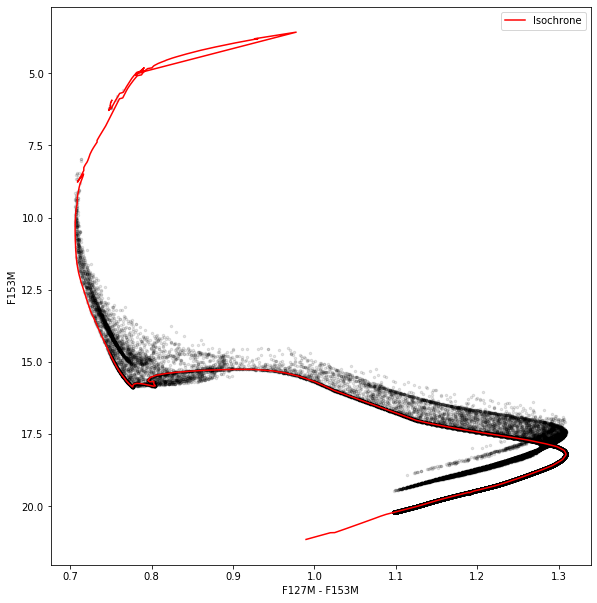

In [13]:
# Look at the cluster CMD, compared to input isochrone. Note the impact of
# multiple systems on the photometry
clust = cluster.star_systems
iso = my_iso.points

py.figure(2, figsize=(10,10))
py.clf()
py.plot(clust['m_hst_f127m'] - clust['m_hst_f153m'], clust['m_hst_f153m'],
       'k.', ms=5, alpha=0.1, label='__nolegend__')
py.plot(iso['m_hst_f127m'] - iso['m_hst_f153m'], iso['m_hst_f153m'],
       'r-', label='Isochrone')
py.xlabel('F127M - F153M')
py.ylabel('F153M')
py.gca().invert_yaxis()
py.legend()

#### Option 2: Resolved cluster with compact objects (white dwarfs, neutron stars, and black holes)
This is quite similar to the above, but includes compact objects. The additional piece of information required is to choose an initial-final mass relation (IFMR.)

The output is the same as if we were making a cluster without using an IFMR. However, you can tell that compact objects are made by looking at the 'phase' keyword. Black holes have 'phase' = 103, neutron stars have 'phase' = 102, and white dwarfs have 'phase' = 101. For these compact objects, the luminosity and temperature will return values of zero, and photometry will return nan, since we are assuming they are totally dark.

Here, we make 4 different clusters, each of mass $10^6 M_\odot$, by taking different combinations of age (either 100 Myr or 10 Gyr) and IMF (top-heavy or Kroupa). We then look at the different distributions of BH and WD masses. 

In [14]:
# Create isochrone object  
filt_list = ['wfc3,ir,f153m'] # We won't be doing much with synthetic photometry here, so only 1 filter
my_ifmr = ifmr.IFMR_Raithel18()
my_iso_young = synthetic.IsochronePhot(8, 0, 10,
                                 evo_model = evolution.MISTv1(),
                                      filters=filt_list)

my_iso_old = synthetic.IsochronePhot(10, 0, 10,
                                 evo_model = evolution.MISTv1(),
                                    filters=filt_list)

In [15]:
# Create IMF objects                                                                                                                                                     
massLimits = np.array([0.1, 0.5, 120])
powers_kroupa = np.array([-1.3, -2.3])
powers_theavy = np.array([-1.3, -1.3]) # top heavy
trunc_kroupa = imf.IMF_broken_powerlaw(massLimits, powers_kroupa)
trunc_theavy = imf.IMF_broken_powerlaw(massLimits, powers_theavy)

In [16]:
# Make clusters                                                                                                                                                          
cluster_mass = 10**6
cluster_young_theavy = synthetic.ResolvedCluster(my_iso_young, trunc_theavy, cluster_mass, ifmr=my_ifmr)
cluster_old_theavy = synthetic.ResolvedCluster(my_iso_old, trunc_theavy, cluster_mass, ifmr=my_ifmr)
cluster_young_kroupa = synthetic.ResolvedCluster(my_iso_young, trunc_kroupa, cluster_mass, ifmr=my_ifmr)
cluster_old_kroupa = synthetic.ResolvedCluster(my_iso_old, trunc_kroupa, cluster_mass, ifmr=my_ifmr)

# Get the outputs
young_theavy = cluster_young_theavy.star_systems
old_theavy = cluster_old_theavy.star_systems
young_kroupa = cluster_young_kroupa.star_systems
old_kroupa = cluster_old_kroupa.star_systems

Found 5586 stars out of mass range
Found 4106 stars out of mass range
Found 99584 stars out of mass range
Found 73734 stars out of mass range


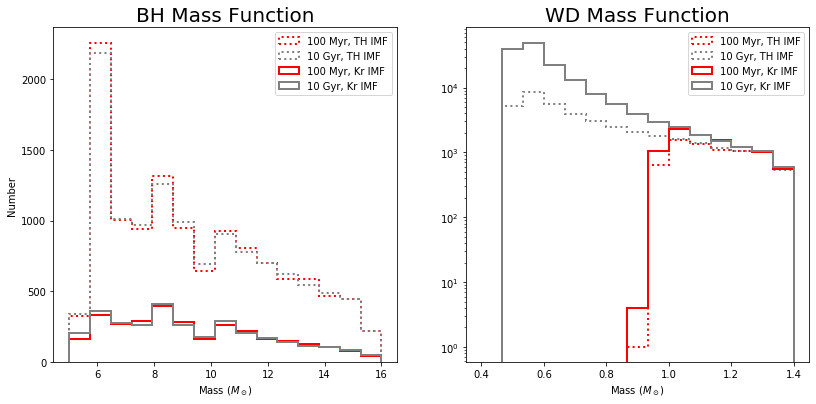

In [17]:
young_theavy_bh_idx = np.where(young_theavy['phase'] == 103)[0]
old_theavy_bh_idx = np.where(old_theavy['phase'] == 103)[0]
young_kroupa_bh_idx = np.where(young_kroupa['phase'] == 103)[0]
old_kroupa_bh_idx = np.where(old_kroupa['phase'] == 103)[0]

bh_bins = np.linspace(5, 16, 16)
wd_bins = np.linspace(0.4, 1.4, 16)

plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.hist(young_theavy[young_theavy_bh_idx]['mass_current'], histtype = 'step',
        bins = bh_bins, label = '100 Myr, TH IMF', color = 'red', linestyle = ':', lw = 2)
plt.hist(old_theavy[old_theavy_bh_idx]['mass_current'], histtype = 'step',
        bins = bh_bins, label = '10 Gyr, TH IMF', color = 'gray', linestyle = ':', lw = 2)
plt.hist(young_kroupa[young_kroupa_bh_idx]['mass_current'], histtype = 'step',
        bins = bh_bins, label = '100 Myr, Kr IMF', color = 'red', lw = 2)
plt.hist(old_kroupa[old_kroupa_bh_idx]['mass_current'], histtype = 'step',
        bins = bh_bins, label = '10 Gyr, Kr IMF', color = 'gray', lw = 2)
plt.title('BH Mass Function')
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

young_theavy_wd_idx = np.where(young_theavy['phase'] == 101)[0]
old_theavy_wd_idx = np.where(old_theavy['phase'] == 101)[0]
young_kroupa_wd_idx = np.where(young_kroupa['phase'] == 101)[0]
old_kroupa_wd_idx = np.where(old_kroupa['phase'] == 101)[0]

plt.subplot(1, 2, 2)
plt.hist(young_theavy[young_theavy_wd_idx]['mass_current'], histtype = 'step',
        bins = wd_bins, label = '100 Myr, TH IMF', color = 'red', linestyle = ':', lw = 2)
plt.hist(old_theavy[old_theavy_wd_idx]['mass_current'], histtype = 'step',
        bins = wd_bins, label = '10 Gyr, TH IMF', color = 'gray', linestyle = ':', lw = 2)
plt.hist(young_kroupa[young_kroupa_wd_idx]['mass_current'], histtype = 'step',
        bins = wd_bins, label = '100 Myr, Kr IMF', color = 'red', lw = 2)
plt.hist(old_kroupa[old_kroupa_wd_idx]['mass_current'], histtype = 'step',
        bins = wd_bins, label = '10 Gyr, Kr IMF', color = 'gray', lw = 2)
plt.yscale('log')
plt.title('WD Mass Function')
plt.xlabel('Mass ($M_\odot$)')
plt.legend()

Plotted above are the distributions of BH and WD masses for clusters of different ages (100 Myr or 10 Gyr), with either a top-heavy or Kroupa IMF. For BHs, since those are formed relatively early on, the age of the cluster does not significantly change the mass distribution as most BHs have already formed by 100 Myr. However, the top heavy IMF allows the creation of many more massive compact objects. For WDs, both the age and IMF make significant differences in the distribution (note y-axis is logscaled).